In [83]:
from features import extract_features
from features import *
%matplotlib inline

In [157]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from features import extract_features
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# Divide up into cars and notcars
vehicle_image_dir = 'vehicles/*/*.png'
nonvehicle_image_dir = 'non-vehicles/*/*.png'
cars = []
notcars = []

images = glob.glob(vehicle_image_dir)
for image in images:
    cars.append(image)
    
images = glob.glob(nonvehicle_image_dir)
for image in images:
    notcars.append(image)
    


In [176]:
hf1, hi1 = calc_hog_features_(cv2.imread("test_images/test1.jpg")[0:56,0:56,0], 9, 8, 1, vis=True, feature_vec=False)
print(hf1.shape)
hf2, hi2 = calc_hog_features_(cv2.imread("test_images/test1.jpg")[0:56,0:56,0], 9, 8, 2, vis=True, feature_vec=False)
print(hf2.shape)

(7L, 7L, 1L, 1L, 9L)
(6L, 6L, 2L, 2L, 9L)


In [177]:
hf1[0,0]

array([[[ 0.24262691,  0.047565  ,  0.2082742 ,  0.07163978,  0.22014327,
          0.06199872,  0.03949457,  0.03871215,  0.06954538]]])

In [178]:
hf2[0,0]

array([[[ 0.09460455,  0.01854644,  0.08120982,  0.02793363,  0.08583778,
          0.0241744 ,  0.01539964,  0.01509456,  0.02711698],
        [ 0.01709329,  0.00678282,  0.00993739,  0.03392637,  0.09164233,
          0.03604132,  0.01022128,  0.00811337,  0.00376614]],

       [[ 0.09127865,  0.01685105,  0.00052187,  0.00270677,  0.04211689,
          0.00116693,  0.01840674,  0.00901857,  0.11363784],
        [ 0.02274957,  0.0072974 ,  0.01261362,  0.00867815,  0.00961742,
          0.01325308,  0.00901749,  0.0056471 ,  0.00797874]]])

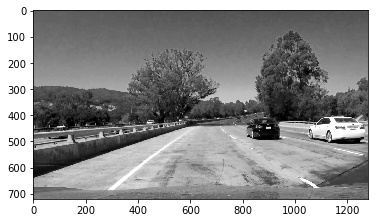

True

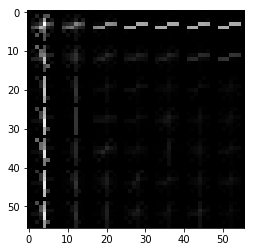

In [180]:
plt.imshow(cv2.imread("test_images/test1.jpg")[:,:,2], cmap='gray')
plt.show()
plt.imshow(hi1, cmap='gray')
cv2.imwrite('hf.jpg', hi2)

In [133]:
print(len(cars))
print(len(notcars))

8792
8968


In [4]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 5000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
h_colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
s_colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, h_cspace=h_colorspace, s_cspace=s_colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, h_cspace=h_colorspace, s_cspace=s_colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

(44.63, 'Seconds to extract HOG features...')


In [5]:
print(len(car_features))

5000


In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_val, y_train, y_val = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 8364)


In [7]:
print(len(X_train))
print(len(scaled_X))

8000
10000


In [8]:
from train_SVM import train_LinearSVC

In [9]:
Lin_clf = train_LinearSVC(X_train, y_train, X_val, y_val)

(3.2, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9985)
('SVC predicts: ', array([ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.]))
('For these', 10, 'labels: ', array([ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.]))
(0.002, 'Seconds to predict', 10, 'labels with SVC')


In [11]:
import pickle

In [77]:
color_spatial_size = 32
svc_dict = {}
svc_dict["svc"] = Lin_clf
svc_dict["scaler"] = X_scaler
svc_dict["orientations"] = orient
svc_dict["pix_per_cell"] = pix_per_cell
svc_dict["cell_per_block"] = cell_per_block
svc_dict["color_spatial_size"] = color_spatial_size
with open('Car_NoCar_LinearSVC.p', 'w') as f:
    pickle.dump(svc_dict, f)

In [14]:
X_scaler2 = pickle.load(open('X_scaler', 'r'))

In [15]:
X_scaler2

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
X_scaler==X_scaler2

False

In [17]:
X_scaler.mean_ == X_scaler2.mean_

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [18]:
with open('Car_NoCar_LinearSVC', 'w') as f:
    pickle.dump(Lin_clf, f)

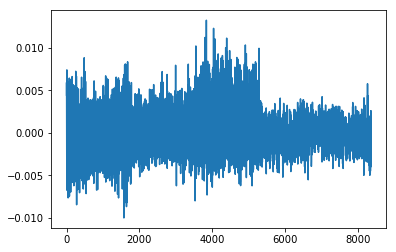

In [74]:
plt.plot(Lin_clf.coef_[0])
plt.show()

In [73]:
Lin_clf.coef_

array([[ 0.00442076,  0.00590068,  0.00222245, ..., -0.00399057,
        -0.00265901,  0.00253039]])

In [79]:
Lin_clf.get_params

<bound method LinearSVC.get_params of LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)>